# Energy Consumption Forecasting for a Utility Company


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
from datetime import datetime, timedelta
import random
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [3]:
# set options to be maximum rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# hide all warnings runtime
import warnings
warnings.filterwarnings('ignore')

In [4]:
# --- Dataset 3: Region Metadata (20 rows) ---
regions = [f"Region_{i+1}" for i in range(20)]
populations = np.random.randint(50000, 500000, size=20)
industrial_density = np.random.choice(['Low', 'Medium', 'High'], size=20)

region_metadata = pd.DataFrame({
    'Region': regions,
    'Population': populations,
    'IndustrialDensity': industrial_density
})

# --- Dataset 1: Energy Consumption (35,000 rows) ---
np.random.seed(42)
start_date = datetime(2022, 1, 1)
timestamps = [start_date + timedelta(minutes=30*i) for i in range(35000)]
regions_sample = np.random.choice(regions, size=35000)
customer_types = np.random.choice(['Residential', 'Commercial'], size=35000)

# Base consumption with random walk + customer/region noise
base_consumption = abs(np.random.normal(30, 10, size=35000))
base_consumption += np.where(customer_types == 'Commercial', 20, 0)
base_consumption += np.array([int(r[-1])*2 for r in regions_sample])

# Add outliers on random holidays
holiday_indices = np.random.choice(range(35000), size=100, replace=False)
base_consumption[holiday_indices] *= np.random.uniform(1.8, 3.0, size=100)

# Introduce 7% missing
missing_indices = np.random.choice(range(35000), size=int(0.07*35000), replace=False)
base_consumption[missing_indices] = np.nan

energy_consumption = pd.DataFrame({
    'Timestamp': timestamps,
    'Consumption': base_consumption,
    'Region': regions_sample,
    'CustomerType': customer_types
})

# --- Dataset 2: Weather Data (10,000 rows) ---
weather_dates = [start_date + timedelta(hours=2*i) for i in range(10000)]
weather_regions = np.random.choice(regions, size=10000)
temps = np.random.normal(22, 6, size=10000)
humidity = np.random.normal(60, 15, size=10000)

# 5% missing humidity
humidity[np.random.choice(range(10000), size=500, replace=False)] = np.nan

weather_data = pd.DataFrame({
    'Date': weather_dates,
    'Region': weather_regions,
    'Temperature': temps,
    'Humidity': humidity
})

# Preview datasets
print("--- Region Metadata ---")
print(region_metadata.head())
print(region_metadata.shape)
print("\n--- Energy Consumption ---")
print(energy_consumption.head())
print(energy_consumption.shape)
print("\n--- Weather Data ---")
print(weather_data.head())
print(weather_data.shape)

--- Region Metadata ---
     Region  Population IndustrialDensity
0  Region_1      387911               Low
1  Region_2      253047            Medium
2  Region_3      412222               Low
3  Region_4      103088               Low
4  Region_5      297848              High
(20, 3)

--- Energy Consumption ---
            Timestamp  Consumption     Region CustomerType
0 2022-01-01 00:00:00          NaN   Region_7  Residential
1 2022-01-01 00:30:00    45.106089  Region_20   Commercial
2 2022-01-01 01:00:00    42.162413  Region_15   Commercial
3 2022-01-01 01:30:00    66.255357  Region_11   Commercial
4 2022-01-01 02:00:00    74.392770   Region_8   Commercial
(35000, 4)

--- Weather Data ---
                 Date     Region  Temperature   Humidity
0 2022-01-01 00:00:00  Region_20    24.013791  78.188921
1 2022-01-01 02:00:00   Region_1    24.884924  73.501054
2 2022-01-01 04:00:00   Region_7    19.988835  56.143885
3 2022-01-01 06:00:00  Region_12    18.777079  10.434227
4 2022-01-01 08:

In [5]:
print("Energy timestamp type:", energy_consumption['Timestamp'].dtype)
print("Weather date type:", weather_data['Date'].dtype)

Energy timestamp type: datetime64[ns]
Weather date type: datetime64[ns]


In [6]:
print("Energy sorted:", energy_consumption['Timestamp'].is_monotonic_increasing)
print("Weather sorted:", weather_data['Date'].is_monotonic_increasing)

Energy sorted: True
Weather sorted: True


In [7]:
print("Energy regions:", energy_consumption['Region'].unique()[:5])
print("Weather regions:", weather_data['Region'].unique()[:5])

Energy regions: ['Region_7' 'Region_20' 'Region_15' 'Region_11' 'Region_8']
Weather regions: ['Region_20' 'Region_1' 'Region_7' 'Region_12' 'Region_11']


### Merging The Data

In [8]:
# We'll collect the merged results per region
merged_parts = []

for region in energy_consumption['Region'].unique():
    ec_region = energy_consumption[energy_consumption['Region'] == region].copy()
    wd_region = weather_data[weather_data['Region'] == region].copy()

    # Make sure both are sorted
    ec_region.sort_values('Timestamp', inplace=True)
    wd_region.sort_values('Date', inplace=True)

    # Use merge_asof
    merged = pd.merge_asof(
        ec_region,
        wd_region,
        left_on='Timestamp',
        right_on='Date',
        direction='backward'
    )

    merged_parts.append(merged)

# Combine everything into one big DataFrame
energy_weather_merged = pd.concat(merged_parts, ignore_index=True)

print(energy_weather_merged.head())
print(energy_weather_merged.shape)
print(energy_weather_merged.info())
print(energy_weather_merged.describe())

df = energy_weather_merged

            Timestamp  Consumption  Region_x CustomerType                Date  \
0 2022-01-01 00:00:00          NaN  Region_7  Residential                 NaT   
1 2022-01-01 02:30:00    42.694408  Region_7  Residential                 NaT   
2 2022-01-01 15:00:00    65.486011  Region_7   Commercial 2022-01-01 04:00:00   
3 2022-01-01 16:00:00    65.901625  Region_7   Commercial 2022-01-01 04:00:00   
4 2022-01-01 20:30:00    51.089951  Region_7   Commercial 2022-01-01 20:00:00   

   Region_y  Temperature   Humidity  
0       NaN          NaN        NaN  
1       NaN          NaN        NaN  
2  Region_7    19.988835  56.143885  
3  Region_7    19.988835  56.143885  
4  Region_7    13.294222  61.392605  
(35000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Timestamp     35000 non-null  datetime64[ns]
 1   Consumption

In [9]:
# Drop Region_y, and keep Region_x as 'Region'
df.drop(columns=['Region_y'], inplace=True)
df.rename(columns={'Region_x': 'Region'}, inplace=True)

In [10]:
df.shape

(35000, 7)

In [11]:
df = df.merge(region_metadata, on='Region', how='left')

In [12]:
df['Date'] = df['Timestamp'].dt.floor('D')

## Step 2: Data Preprocessing & Feature Engineering

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Timestamp          35000 non-null  datetime64[ns]
 1   Consumption        32550 non-null  float64       
 2   Region             35000 non-null  object        
 3   CustomerType       35000 non-null  object        
 4   Date               35000 non-null  datetime64[ns]
 5   Temperature        34924 non-null  float64       
 6   Humidity           32958 non-null  float64       
 7   Population         35000 non-null  int32         
 8   IndustrialDensity  35000 non-null  object        
dtypes: datetime64[ns](2), float64(3), int32(1), object(3)
memory usage: 2.3+ MB


### Handling Missing Values

In [14]:
df.isnull().sum() / len(df) * 100

Timestamp            0.000000
Consumption          7.000000
Region               0.000000
CustomerType         0.000000
Date                 0.000000
Temperature          0.217143
Humidity             5.834286
Population           0.000000
IndustrialDensity    0.000000
dtype: float64

In [15]:
df.describe()

,Timestamp,Consumption,Date,Temperature,Humidity,Population
count,35000,32550.000000,35000,34924.000000,32958.000000,35000.000000
mean,2022-12-31 13:45:00,49.473361,2022-12-31 02:00:08.228571392,22.182152,60.011103,283949.188571
min,2022-01-01 00:00:00,1.009645,2022-01-01 00:00:00,-0.488260,3.616314,56126.000000
25%,2022-07-02 06:52:30,38.348272,2022-07-02 00:00:00,18.009202,49.692085,147571.000000
50%,2022-12-31 13:45:00,49.348570,2022-12-31 00:00:00,22.287542,60.178315,297848.000000
75%,2023-07-01 20:37:30,60.261759,2023-07-01 00:00:00,26.397341,70.239837,425561.000000
max,2023-12-31 03:30:00,211.936395,2023-12-31 00:00:00,44.171162,113.823019,483832.000000
std,NaN,15.805559,NaN,5.961086,15.097250,137303.345801


In [16]:
# Interpolate Temperature
temp_interp = (
    df.groupby('Region')
      .apply(lambda group: group.set_index('Timestamp')['Temperature']
                            .interpolate(method='time'))
      .reset_index()
)

# Interpolate Humidity
hum_interp = (
    df.groupby('Region')
      .apply(lambda group: group.set_index('Timestamp')['Humidity']
                            .interpolate(method='time'))
      .reset_index()
)

# Merge back the interpolated values by Timestamp and Region
df = df.merge(temp_interp, on=['Region', 'Timestamp'], how='left', suffixes=('', '_interp'))
df = df.merge(hum_interp, on=['Region', 'Timestamp'], how='left', suffixes=('', '_interp'))

# Replace original with interpolated values
df['Temperature'] = df['Temperature_interp']
df['Humidity'] = df['Humidity_interp']

# Drop helper columns
df.drop(columns=['Temperature_interp', 'Humidity_interp'], inplace=True)


In [17]:
# Final edge fill (within each region)
df['Temperature'] = df.groupby('Region')['Temperature'].transform(lambda x: x.ffill().bfill())
df['Humidity'] = df.groupby('Region')['Humidity'].transform(lambda x: x.ffill().bfill())

In [18]:
df.isnull().sum() / len(df) * 100

Timestamp            0.0
Consumption          7.0
Region               0.0
CustomerType         0.0
Date                 0.0
Temperature          0.0
Humidity             0.0
Population           0.0
IndustrialDensity    0.0
dtype: float64

In [19]:
# 1. Encode categoricals
df['CustomerType_code'] = df['CustomerType'].map({'Residential': 0, 'Commercial': 1})
df['IndustrialDensity_code'] = df['IndustrialDensity'].map({'Low': 0, 'Medium': 1, 'High': 2})

# 2. Create time-based features
df['hour'] = df['Timestamp'].dt.hour
df['weekday'] = df['Timestamp'].dt.weekday
df['month'] = df['Timestamp'].dt.month

# 3. Define features to use for prediction
features = [
    'CustomerType_code', 'IndustrialDensity_code', 'Population',
    'Temperature', 'Humidity', 'hour', 'weekday', 'month'
]

# 4. Training data: only rows with known Consumption
train_df = df[df['Consumption'].notna()]

In [20]:
from sklearn.ensemble import RandomForestRegressor

# 1. Train/test split (only for imputation, not final forecast)
X_train = train_df[features]
y_train = train_df['Consumption']

# 2. Fit the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 3. Predict missing Consumption
missing_df = df[df['Consumption'].isna()]
X_missing = missing_df[features]
predicted_consumption = rf_model.predict(X_missing)

# 4. Fill missing values
df.loc[df['Consumption'].isna(), 'Consumption'] = predicted_consumption

In [21]:
df.isnull().sum() / len(df) * 100

Timestamp                 0.0
Consumption               0.0
Region                    0.0
CustomerType              0.0
Date                      0.0
Temperature               0.0
Humidity                  0.0
Population                0.0
IndustrialDensity         0.0
CustomerType_code         0.0
IndustrialDensity_code    0.0
hour                      0.0
weekday                   0.0
month                     0.0
dtype: float64

### Checking Outliers

In [22]:
def check_outliers(df):
    outlier_summary = {}

    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)][col]
        outlier_summary[col] = {
            "count": len(outliers),
            "percent": round(100 * len(outliers) / len(df), 2)
        }

    return pd.DataFrame(outlier_summary).T.sort_values(by="percent", ascending=False)

In [23]:
outlier_report = check_outliers(df)
print(outlier_report)

                        count  percent
Humidity                246.0     0.70
Temperature             152.0     0.43
Consumption             111.0     0.32
Population                0.0     0.00
CustomerType_code         0.0     0.00
IndustrialDensity_code    0.0     0.00
hour                      0.0     0.00
weekday                   0.0     0.00
month                     0.0     0.00


# 3. Modeling

## Prophet Model

In [24]:
from prophet import Prophet

# Step 1: Create Prophet-compatible DataFrame
prophet_df = df[['Timestamp', 'Consumption']].copy()
prophet_df.rename(columns={'Timestamp': 'ds', 'Consumption': 'y'}, inplace=True)

# Optional: downsample to daily total to reduce noise
daily_df = prophet_df.resample('D', on='ds').mean().reset_index()

In [25]:
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(daily_df)

19:51:49 - cmdstanpy - INFO - Chain [1] start processing
19:51:49 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

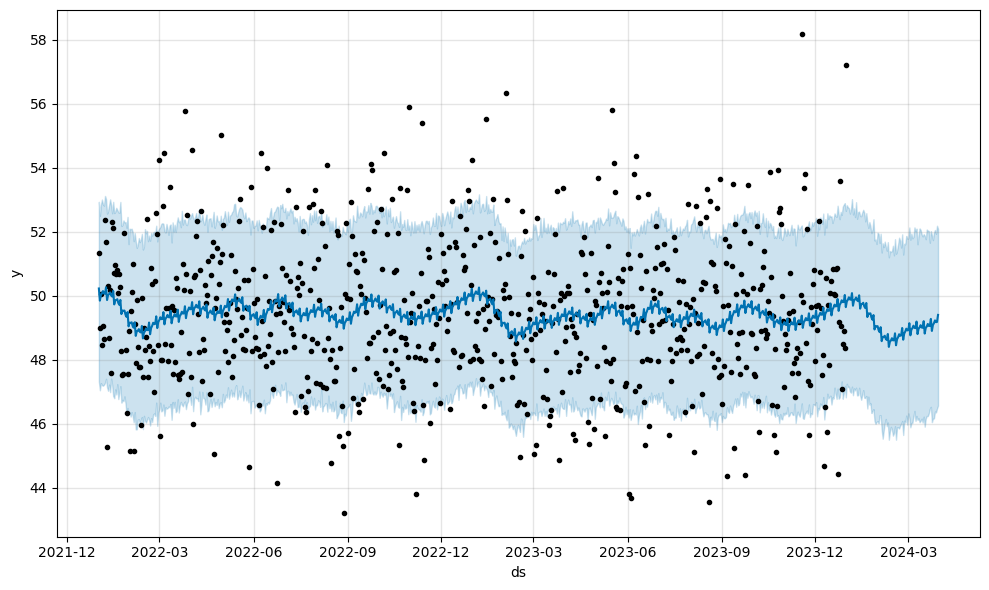

In [27]:
model.plot(forecast);

In [28]:
# Keep only the rows where we have actual values (not future)
merged = daily_df.merge(
    forecast[['ds', 'yhat']],
    on='ds',
    how='left'
).dropna()

In [29]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

mape = mean_absolute_percentage_error(merged['y'], merged['yhat']) * 100
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f} kWh")

MAPE: 3.53%
RMSE: 2.22 kWh


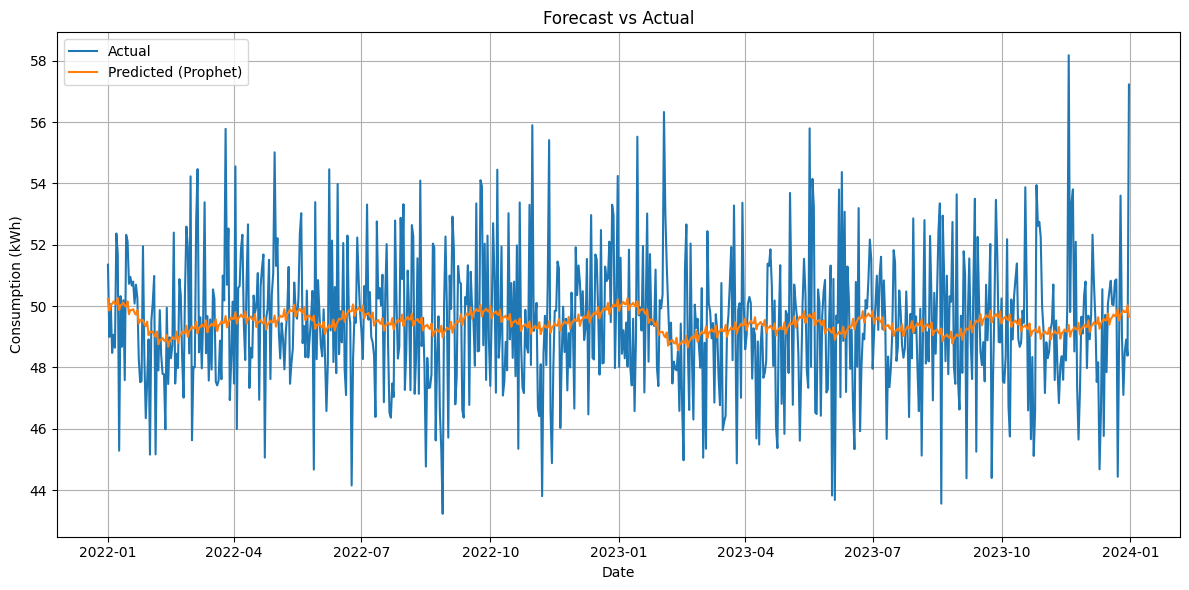

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(merged['ds'], merged['y'], label='Actual')
plt.plot(merged['ds'], merged['yhat'], label='Predicted (Prophet)')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.title('Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

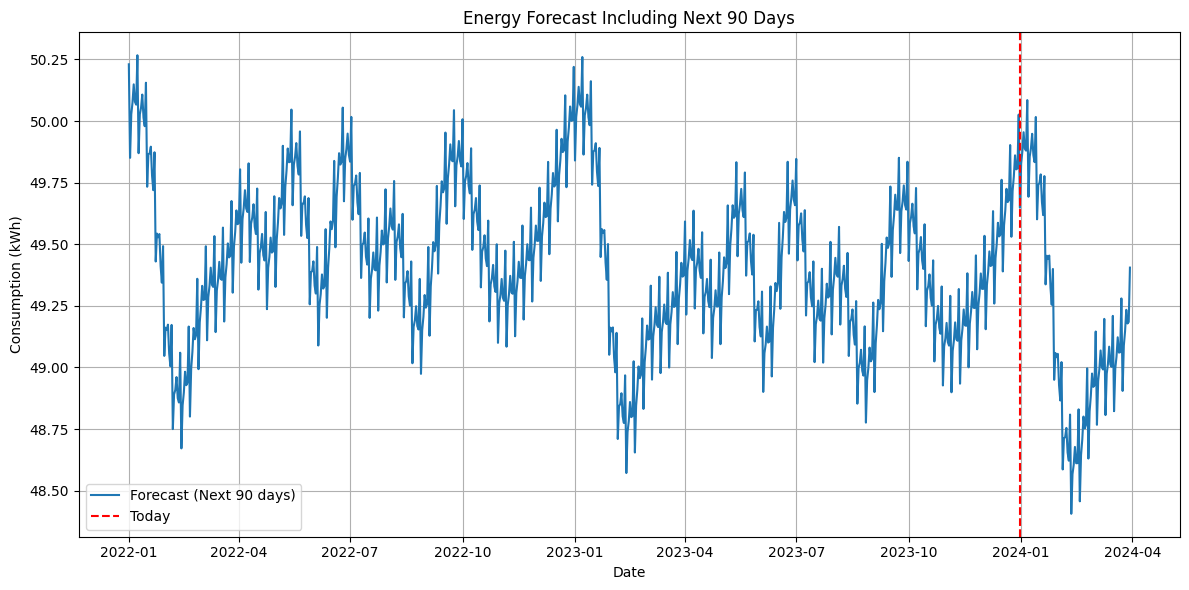

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast (Next 90 days)')
plt.axvline(x=daily_df['ds'].max(), color='red', linestyle='--', label='Today')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.title('Energy Forecast Including Next 90 Days')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

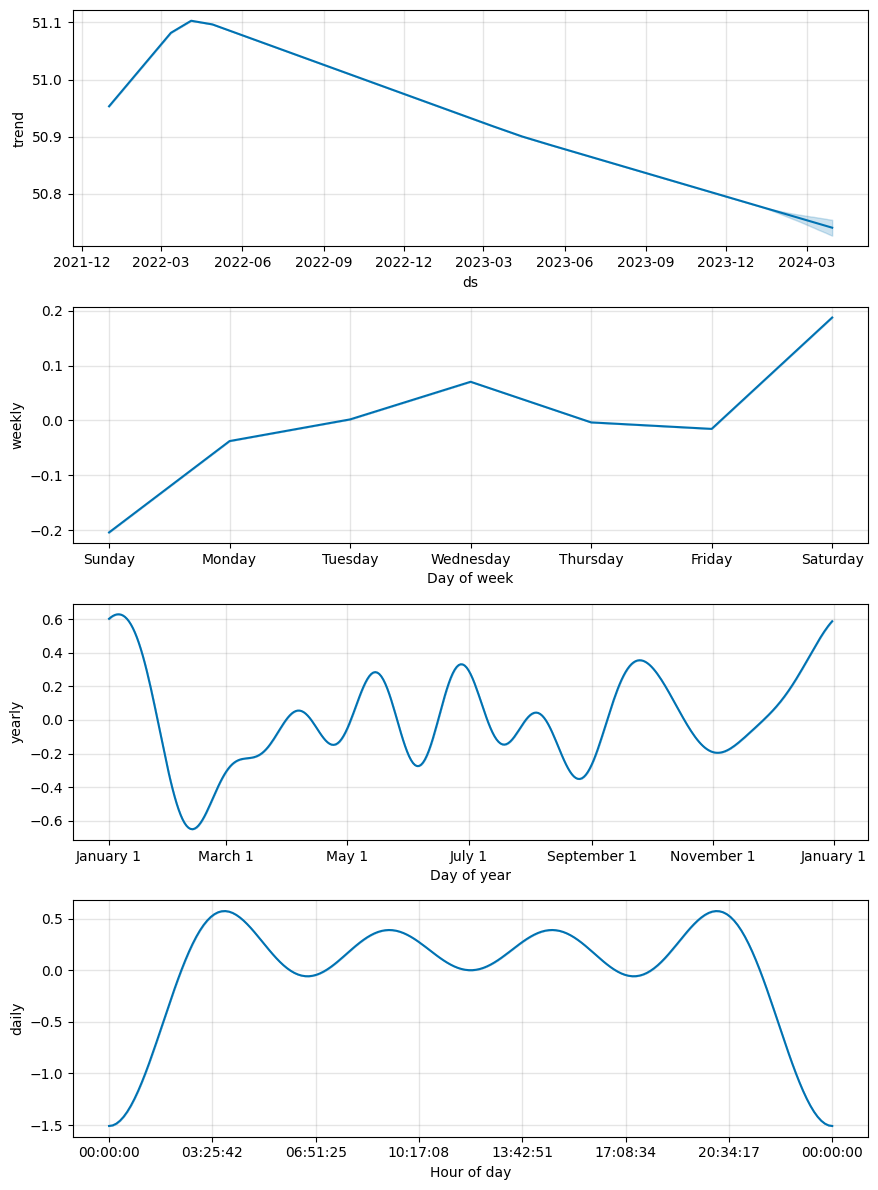

In [32]:
model.plot_components(forecast);

In [33]:
# Get only future forecast rows
future_only = forecast[forecast['ds'] > daily_df['ds'].max()].copy()

# Top 10 highest forecasted consumption days
top_peaks = future_only.sort_values('yhat', ascending=False).head(10)

print(top_peaks[['ds', 'yhat']])

            ds       yhat
735 2024-01-06  50.085135
742 2024-01-13  50.016523
732 2024-01-03  49.954627
739 2024-01-10  49.948311
738 2024-01-09  49.889223
733 2024-01-04  49.887315
734 2024-01-05  49.880011
731 2024-01-02  49.877257
740 2024-01-11  49.861428
737 2024-01-08  49.856043


In [34]:
import pandas as pd

# 1. Only future predictions
cutoff = daily_df['ds'].max()
future_only = forecast[forecast['ds'] > cutoff].copy()

# Add helper columns
future_only['month'] = future_only['ds'].dt.month
future_only['weekday'] = future_only['ds'].dt.weekday  # 0 = Mon, 6 = Sun

# 2. Peak demand month
peak_month = (
    future_only.groupby('month')['yhat']
    .mean()
    .sort_values(ascending=False)
    .idxmax()
)

# 3. Weekday vs weekend
weekday_mean = future_only[future_only['weekday'] < 5]['yhat'].mean()
weekend_mean = future_only[future_only['weekday'] >= 5]['yhat'].mean()

# 4. Lowest demand window (for maintenance)
low_period = (
    future_only.sort_values('yhat')
    .head(5)['ds']
    .dt.strftime('%B %d')
    .tolist()
)

# 5. Output Recommendations
print("🔹 Predicted peak demand will occur in", pd.to_datetime(f'2024-{peak_month}-01').strftime('%B') + 
      ". Recommend increasing capacity during this period.")

if weekday_mean > weekend_mean + 1:  # 1 kWh margin
    print("🔹 Weekday energy usage is higher than weekends. Recommend surge buffers Mon–Fri.")

print(f"🔹 Lowest demand is forecasted around: {', '.join(low_period)}. Good window for maintenance scheduling.")


🔹 Predicted peak demand will occur in January. Recommend increasing capacity during this period.
🔹 Lowest demand is forecasted around: February 11, February 18, February 12, February 04, February 13. Good window for maintenance scheduling.


## ARIMA

In [35]:
# Rebuild daily_df with daily sum
daily_df_arima = prophet_df.resample('D', on='ds').mean().reset_index()
daily_df_arima .rename(columns={'ds': 'Date', 'y': 'Consumption'}, inplace=True)
daily_series = daily_df_arima.set_index('Date')['Consumption']
daily_series.index.freq = 'D'

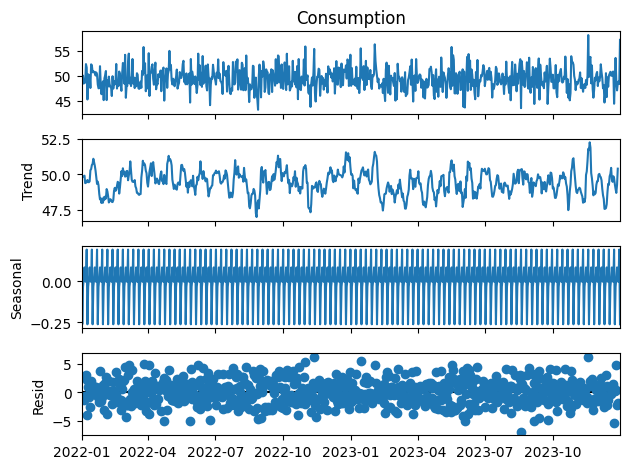

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomp = seasonal_decompose(daily_series, model='additive', period=7)  # Weekly seasonality

decomp.plot()
plt.tight_layout()
plt.show()

In [37]:
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron

# ADF Test (null: non-stationary)
adf_result = adfuller(daily_series)
print("ADF Test p-value:", adf_result[1])

# KPSS Test (null: stationary)
kpss_result = kpss(daily_series, regression='c')
print("KPSS Test p-value:", kpss_result[1])

# PP Test (null: non-stationary)
pp_result = PhillipsPerron(daily_series)
print("PP Test p-value:", pp_result.pvalue)

ADF Test p-value: 0.0
KPSS Test p-value: 0.1
PP Test p-value: 0.0


C:\Users\Shazil Naeem\AppData\Local\Temp\ipykernel_7392\3288823933.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(daily_series, regression='c')


In [38]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import plotly.graph_objects as go

# Fit on full series with no differencing
model = ARIMA(daily_series, order=(5, 0, 2))
model_fit = model.fit()

# Forecast 90 days
forecast_90 = model_fit.forecast(steps=90)
future_dates = pd.date_range(start=daily_series.index.max() + pd.Timedelta(days=1), periods=90)

# Combine forecast
forecast_df = pd.DataFrame({
    'ds': future_dates,
    'yhat': forecast_90
})

In [39]:
fig = go.Figure()

# Historical
fig.add_trace(go.Scatter(
    x=daily_series.index,
    y=daily_series.values,
    name='Historical (Daily Sum)',
    line=dict(color='lightblue')
))

# ARIMA Forecast
fig.add_trace(go.Scatter(
    x=forecast_df['ds'],
    y=forecast_df['yhat'],
    name='ARIMA Forecast (90 Days)',
    line=dict(color='orange')
))

fig.update_layout(
    title='ARIMA 90-Day Forecast',
    xaxis_title='Date',
    yaxis_title='Consumption (kWh)',
    template='plotly_white'
)

fig.show()


In [40]:
# Combine ARIMA forecast with dates
arima_forecast_90 = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Consumption_kWh': forecast_90
})

# Display top rows
print(arima_forecast_90.head(10))  # or .to_csv('arima_forecast.csv') to save

                 Date  Predicted_Consumption_kWh
2024-01-01 2024-01-01                  49.415048
2024-01-02 2024-01-02                  49.589776
2024-01-03 2024-01-03                  49.606973
2024-01-04 2024-01-04                  49.522702
2024-01-05 2024-01-05                  48.926407
2024-01-06 2024-01-06                  49.368950
2024-01-07 2024-01-07                  49.239613
2024-01-08 2024-01-08                  49.356386
2024-01-09 2024-01-09                  49.353462
2024-01-10 2024-01-10                  49.431375


In [41]:
arima_forecast_90.describe()

,Date,Predicted_Consumption_kWh
count,90,90.000000
mean,2024-02-14 12:00:00,49.432919
min,2024-01-01 00:00:00,48.926407
25%,2024-01-23 06:00:00,49.439351
50%,2024-02-14 12:00:00,49.439351
75%,2024-03-07 18:00:00,49.439351
max,2024-03-30 00:00:00,49.606973
std,NaN,0.065135


In [ ]:
# Changing Order
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import plotly.graph_objects as go

# Fit on full series with no differencing
model = ARIMA(daily_series, order=(75, 0, 75))
model_fit = model.fit()

# Forecast 90 days
forecast_90 = model_fit.forecast(steps=90)
future_dates = pd.date_range(start=daily_series.index.max() + pd.Timedelta(days=1), periods=90)

# Combine forecast
forecast_df = pd.DataFrame({
    'ds': future_dates,
    'yhat': forecast_90
})

c:\Users\Shazil Naeem\miniconda3\envs\python_eda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [43]:
fig = go.Figure()

# Historical
fig.add_trace(go.Scatter(
    x=daily_series.index,
    y=daily_series.values,
    name='Historical (Daily Sum)',
    line=dict(color='lightblue')
))

# ARIMA Forecast
fig.add_trace(go.Scatter(
    x=forecast_df['ds'],
    y=forecast_df['yhat'],
    name='ARIMA Forecast (90 Days)',
    line=dict(color='orange')
))

fig.update_layout(
    title='ARIMA 90-Day Forecast (Final, Properly Fitted)',
    xaxis_title='Date',
    yaxis_title='Consumption (kWh)',
    template='plotly_white'
)

fig.show()


In [44]:
# Combine ARIMA forecast with dates
arima_forecast_90 = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Consumption_kWh': forecast_90
})

# Display top rows
print(arima_forecast_90.head(10))  # or .to_csv('arima_forecast.csv') to save


                 Date  Predicted_Consumption_kWh
2024-01-01 2024-01-01                  49.903531
2024-01-02 2024-01-02                  49.452724
2024-01-03 2024-01-03                  48.482261
2024-01-04 2024-01-04                  48.980994
2024-01-05 2024-01-05                  49.217652
2024-01-06 2024-01-06                  50.555254
2024-01-07 2024-01-07                  46.382779
2024-01-08 2024-01-08                  51.415449
2024-01-09 2024-01-09                  50.953788
2024-01-10 2024-01-10                  48.431556


In [45]:
arima_forecast_90.describe()

,Date,Predicted_Consumption_kWh
count,90,90.000000
mean,2024-02-14 12:00:00,49.464874
min,2024-01-01 00:00:00,46.382779
25%,2024-01-23 06:00:00,48.922892
50%,2024-02-14 12:00:00,49.407616
75%,2024-03-07 18:00:00,50.102295
max,2024-03-30 00:00:00,51.415449
std,NaN,0.984095
